In [29]:
import torch
import os
from skimage import io
import numpy as np
import pandas as pd
import torchvision.transforms as ts
from torch.utils.data import DataLoader, random_split
from dataset import PotholeDataset
from model import ALEXNET
from engine import fit, get_default_device, to_device
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import zipfile
with zipfile.ZipFile("./input/all_data.zip","r") as zipf:
  zipf.extractall("./input/")

In [12]:
device = get_default_device()
images_path="./input/all_data/"
train_df=pd.read_csv("./input/train_ids_labels.csv")
stats=((0.5,0.5,0.5),(0.5,0.5,0.5))
tfms=ts.Compose([ts.ToTensor(),
                ts.CenterCrop((120,800)),
                ts.Resize((227,227)),
                ts.Normalize(*stats)])
dataset=PotholeDataset(images_path,train_df,transform=tfms)
len(dataset)

4026

In [13]:
batch_size=64
train_ds,val_ds=random_split(dataset,[len(dataset)-500,500])
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
model=ALEXNET(2)
to_device(model,device)

ALEXNET(
  (network): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=9216, out_features=4096, bias=True)
    (16): ReLU(inplace=True)
    (17): Dropout(p=0.5, in

In [24]:
run1=fit(10,0.001,model,train_loader,val_loader,device,opt_func=torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0]: train_loss 0.7101, val_loss 0.8613, val_acc 0.5477
Epoch [1]: train_loss 0.5087, val_loss 0.5200, val_acc 0.7992
Epoch [2]: train_loss 0.4214, val_loss 0.3405, val_acc 0.8623
Epoch [3]: train_loss 0.3494, val_loss 0.4254, val_acc 0.8152
Epoch [4]: train_loss 0.3197, val_loss 0.2926, val_acc 0.8930
Epoch [5]: train_loss 0.2990, val_loss 0.2708, val_acc 0.8891
Epoch [6]: train_loss 0.3105, val_loss 0.4524, val_acc 0.7793
Epoch [7]: train_loss 0.3228, val_loss 0.2900, val_acc 0.8714
Epoch [8]: train_loss 0.2800, val_loss 0.2495, val_acc 0.8930
Epoch [9]: train_loss 0.2706, val_loss 0.2651, val_acc 0.8930


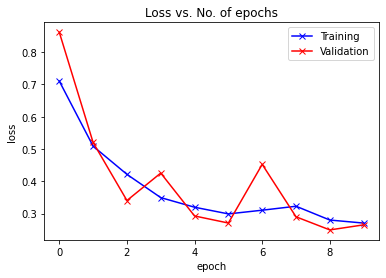

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(run1)

In [25]:
test_df=pd.read_csv("./input/test_ids_only.csv")
test_df.head()

,Image_ID
0,nRhHxqLhDlJsiXc
1,gbSntVovxgHQrmO
2,nqOobGmvgEOiPms
3,oIkPTooLcIbZKlF
4,eSKxsTTJDQzkjgD


In [26]:
preds=[]
with torch.no_grad():
  for i in range(len(test_df)):
    img_name=os.path.join(images_path,test_df.iloc[i,0])
    img_name=img_name + ".JPG"
    img=io.imread(img_name)
    img=img.astype(np.uint8)
    img=tfms(img)
    img = to_device(img.unsqueeze(0), device)

    out=model(img)



    _, pred  = torch.max(out, dim=1)


    preds.append([test_df.iloc[i,0],pred[0].item()])


In [27]:
predictions=pd.DataFrame(preds,columns=["Image_ID","Label"])
print(len(predictions))
predictions.head()

1650


,Image_ID,Label
0,nRhHxqLhDlJsiXc,1
1,gbSntVovxgHQrmO,1
2,nqOobGmvgEOiPms,0
3,oIkPTooLcIbZKlF,1
4,eSKxsTTJDQzkjgD,1
